## Line chart dengan matplotlib

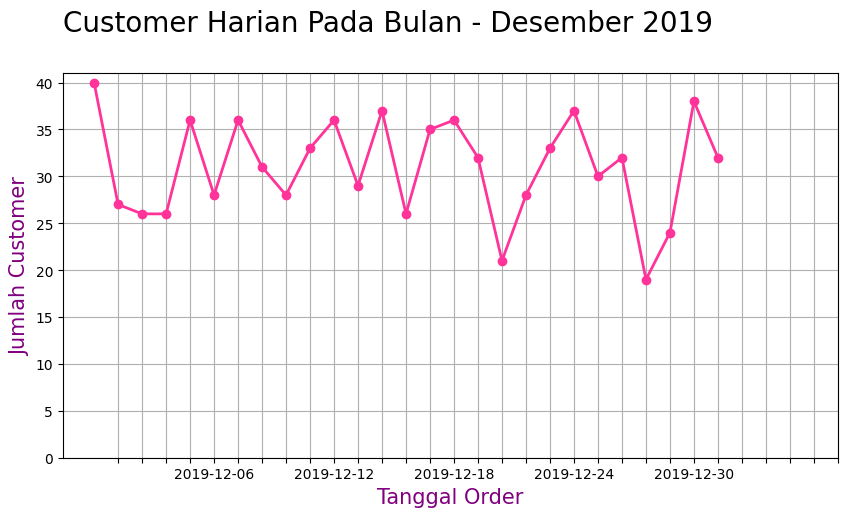

In [185]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Memuat dataset
# url = 'https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/retail_raw_reduced.csv'
df = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/retail_raw_reduced.csv')
# Mengubah kolom order_date menjadi tipe data datetime
df['order_month'] = df['order_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%Y-%m'))
# Menambahkan Kolom Untuk GMV
df['gmv'] = df['item_price'] * df['quantity']
# Mencetak Line Chart
plt.figure(figsize=(10, 5))
df[df['order_month']=='2019-12'].groupby(['order_date'])['customer_id'].nunique().plot(kind='line',color='#FF3399', marker='o', linewidth=2)
plt.title('Customer Harian Pada Bulan - Desember 2019', loc='left', pad=30, fontsize=20, color='black')
plt.xlabel('Tanggal Order', fontsize=15, color='#800080')
plt.ylabel('Jumlah Customer', fontsize=15, color='#800080')
plt.xticks(range(1, 32))
plt.grid(True)
plt.ylim(ymin=0)
plt.show()

## Case 1 Menentukan Brand Top 5

In [186]:
#mengambil informasi top 5 brands berdasarkan quantity
top_5_brands = (df[df['order_month']=='2019-12'].groupby('brand')['quantity']
                .sum()
                .reset_index()
                .sort_values(by='quantity',ascending=False)
                .head(5))#membuat dataframe baru, filter hanya di bulan Desember 2019 dan hanya top 5 brands
df_top_5_brands = df[(df['order_month']=='2019-12') & (df['brand'].isin(top_5_brands['brand'].to_list()))]# print top brands
print(top_5_brands)


     brand  quantity
8  BRAND_S      2197
6  BRAND_P      2194
7  BRAND_R      1508
2  BRAND_C      1365
0  BRAND_A      1315


## Case 2 Lonjakan Top 5 Brand

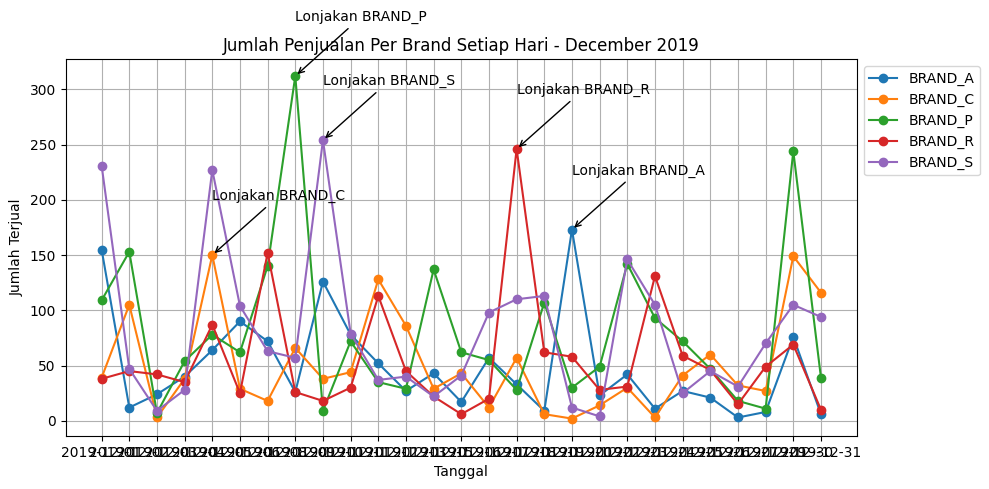

In [187]:

# Menghitung total quantity per brand per tanggal
daily_quantity = df_top_5_brands.groupby(['order_date', 'brand'])['quantity'].sum().unstack()

# Membuat multi-line chart
plt.figure(figsize=(10, 5))
for brand in daily_quantity.columns:
    plt.plot(daily_quantity.index, daily_quantity[brand], marker='o', label=brand)

# Menambahkan anotasi untuk titik lonjakan
lonjakan_date = daily_quantity.idxmax()
lonjakan_value = daily_quantity.max()
for brand in lonjakan_date.index:
    plt.annotate(f'Lonjakan {brand}', xy=(lonjakan_date[brand], lonjakan_value[brand]), xytext=(lonjakan_date[brand], lonjakan_value[brand]+50), arrowprops=dict(facecolor='red', arrowstyle='->'))

# Mengatur judul, label sumbu-x, sumbu-y, dan legenda
plt.title('Jumlah Penjualan Per Brand Setiap Hari - December 2019')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Terjual')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Menampilkan multi-line chart
plt.show()


## Case 3 Penjualan Produk Dari Masing-Masing Brand

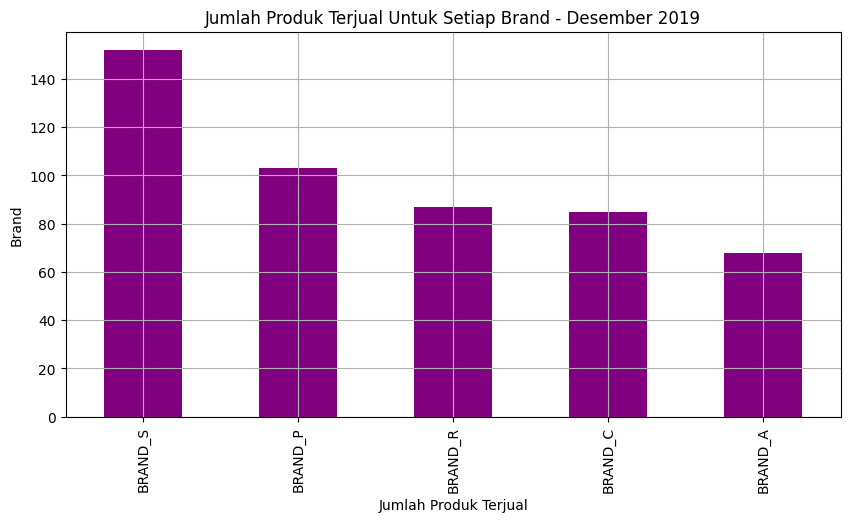

In [189]:
# Menghitung jumlah product terjual untuk masing-masing brand
jumlah_product_brand = df_top_5_brands.groupby('brand')['product_id'].nunique()

# Mengurutkan brand berdasarkan jumlah product terjual secara menurun
jumlah_product_brand = jumlah_product_brand.sort_values(ascending=False)

# Membuat barchart
plt.figure(figsize=(10, 5))
jumlah_product_brand.plot(kind='bar', color='purple')
plt.title('Jumlah Produk Terjual Untuk Setiap Brand - Desember 2019')
plt.xlabel('Jumlah Produk Terjual')
plt.ylabel('Brand')
plt.grid(True)

# Menampilkan barchart
plt.show()


## Case 4 Stacked Chart

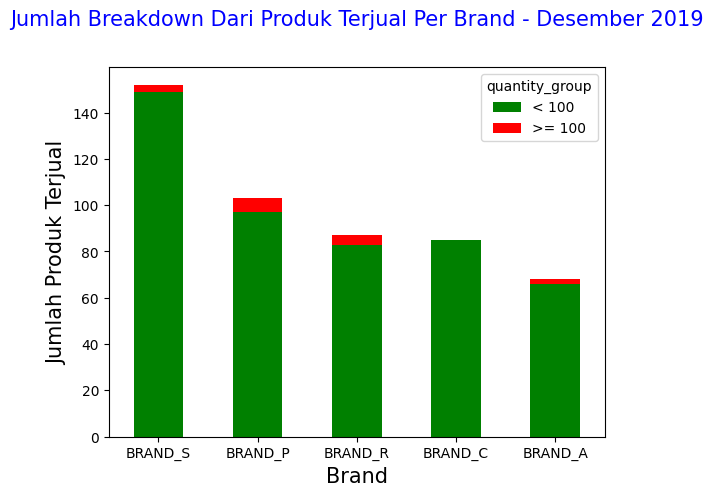

In [190]:
# Membuat dataframe baru, untuk agregat jumlah quantity terjual per product
top5_brand_per_produk = df_top_5_brands.groupby(['brand','product_id'])['quantity'].sum().reset_index()
# Membuat kolom baru untuk menandai product yang terjual >= 100 dan <100
top5_brand_per_produk['quantity_group'] = top5_brand_per_produk['quantity'].apply(lambda x: '>= 100' if x>=100 else '< 100')
top5_brand_per_produk.sort_values('quantity',ascending=False,inplace=True)
# Mengurutan brand berdasarkan banyaknya semua product
s_sort = top5_brand_per_produk.groupby('brand')['product_id'].nunique().sort_values(ascending=False)
colors = ['green',  'red'] 
top5_brand_per_produk.groupby(['brand','quantity_group'])['product_id'].nunique().reindex(index=s_sort.index, level='brand').unstack().plot(kind='bar', stacked=True, color=colors)

# Menampilkan stacked chart
plt.title('Jumlah Breakdown Dari Produk Terjual Per Brand - Desember 2019',loc='center',pad=30, fontsize=15, color='blue')
plt.xlabel('Brand', fontsize = 15)
plt.ylabel('Jumlah Produk Terjual',fontsize = 15)
plt.ylim(ymin=0)
plt.xticks(rotation=0)

plt.show()


## Case 5 Histogram

(0.0, 2000000.0)

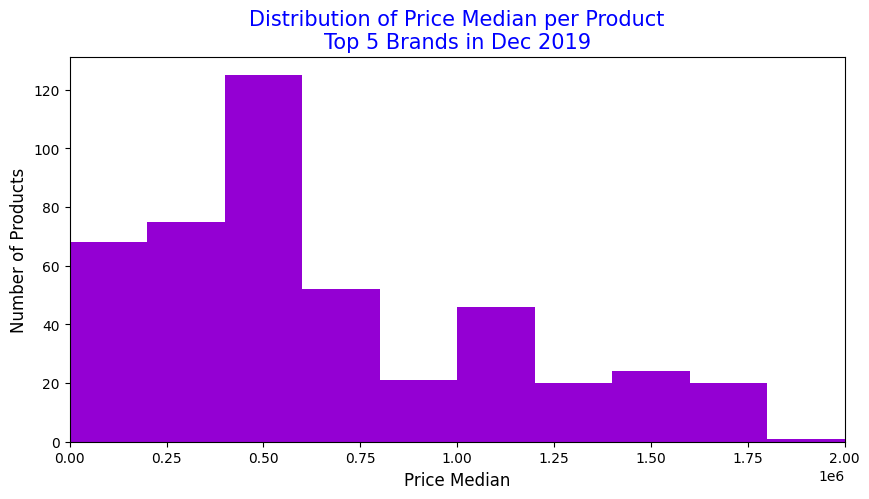

In [191]:

# Menghitung median harga produk untuk setiap product_id di top 5 brand
plt.figure(figsize=(10, 5))
plt.hist(df_top_5_brands.groupby('product_id')['item_price'].median(), bins=10, stacked=True, range=(1,2000000), color='#9400D3')
plt.title('Distribution of Price Median per Product\nTop 5 Brands Distribusi Median Harga Per Produk Top 5 Brand di Desember 2019',fontsize=15, color='blue')
plt.xlabel('Price Median', fontsize = 12)
plt.ylabel('Number of Products',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)

## Case 6A

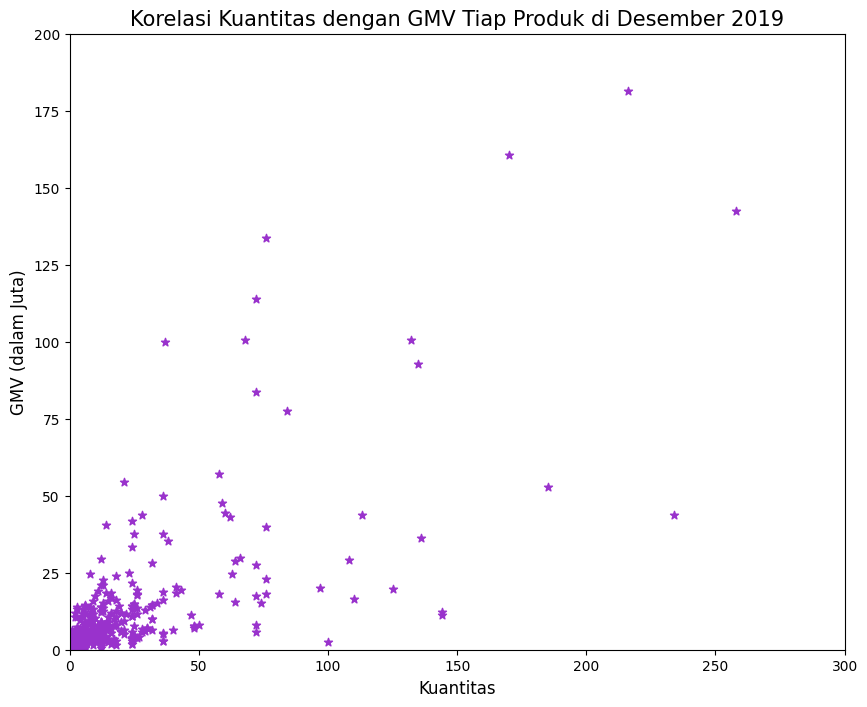

In [210]:
# Pengumpulan Data Per Produk
data_tiap_produk = df_top_5_brands.groupby('product_id').agg({'quantity': 'sum', 'gmv':'sum', 'item_price':'median'}).reset_index()

#Mencetak Scatter Plot
plt.figure(figsize=(10,8))
plt.scatter(data_tiap_produk['quantity'],data_tiap_produk['gmv'], marker='*', color='#9932CC')
plt.title('Korelasi Kuantitas dengan GMV Tiap Produk di Desember 2019',fontsize=15, color='black')
plt.xlabel('Kuantitas', fontsize = 12)
plt.ylabel('GMV (dalam Juta)',fontsize = 12)
plt.xlim(xmin=0,xmax=300)
plt.ylim(ymin=0,ymax=200000000)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/1000000).astype(int))
plt.show()

Dari hasil scatterplot dapat dilihat bahwa terdapat kecenderungan penjualan produk dengan harga yang lebih rendah dalam jumlah yang lebih besar. Hal ini menunjukkan adanya kecenderungan hubungan negatif atau invers antara kuantitas dan GMV.
Artinya, semakin tinggi kuantitas suatu produk, maka GMV (Gross Merchandise Value) cenderung lebih rendah. Ini bisa diindikasikan oleh pola penyebaran titik-titik pada scatter plot yang lebih banyak berada di area kuantitas rendah dan GMV rendah.

## Case 6B

(0.0, 250.0)

<Figure size 640x480 with 0 Axes>

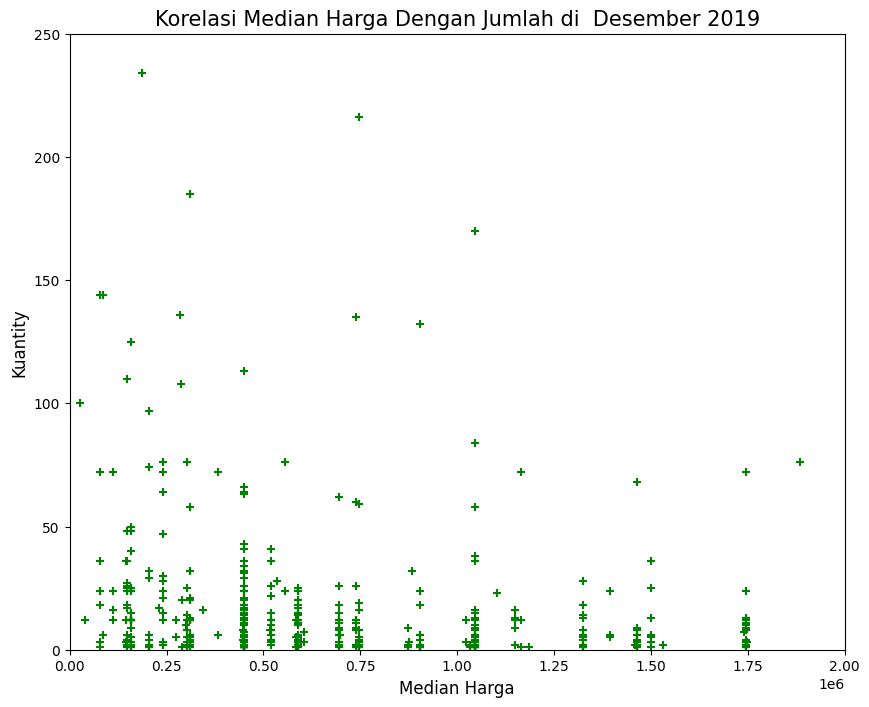

In [208]:
plt.clf()
# Pengumpulan Data Per Produk
data_tiap_produk = df_top_5_brands.groupby('product_id').agg({'quantity': 'sum', 'gmv':'sum', 'item_price':'median'}).reset_index()
# Mencetak scatter plot
plt.figure(figsize=(10,8))
plt.scatter(data_tiap_produk['item_price'],data_tiap_produk['quantity'], marker='+', color='green')
plt.title('Korelasi Median Harga Dengan Kuantitas di  Desember 2019',fontsize=15, color='black')
plt.xlabel('Median Harga', fontsize = 12)
plt.ylabel('Kuantitas',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)
plt.ylim(ymin=0,ymax=250)

Median harga (Item Price) dengan kuantitas (Quantity) lebih banyak terkonsentrasi di area quantity dengan nilai kecil dan lebih banyak di median harga dengan nilai kecil, hal ini menunjukkan adanya kecenderungan hubungan negatif atau invers antara median harga dan kuantitas.
Artinya, semakin tinggi median harga suatu produk, maka kuantitas cenderung lebih rendah. Ini bisa diindikasikan oleh pola penyebaran titik-titik pada scatter plot yang lebih banyak berada di area kuantitas rendah dan median harga rendah.Dengan kemungkinan terdapat : hubungan harga yang lebih tinggi dengan permintaan yang lebih rendah. Produk dengan harga yang lebih tinggi cenderung memiliki permintaan yang lebih sedikit.